# Austin Python Meetup - An Evening of Python Coding
### Tuesday Jan 30, 2018
____

# Using Python + Pandas instead of Excel
### Danny Mulligan, danny@dannymulligan.com

## This presentation is available on GitHub at
### https://github.com/dannymulligan/public/tree/master/Austin_Python_Meetup/Using_Python_instead_of_Excel.html

## Why we're doing this
All of these cool Python tools we're learning about don't help us unless we find a way to actually use them at work.

Basic data processing at work is usually done in Excel.  There are lots of good reasons to do this, but Excel has a number of disadvantages, and limits.

- Finding an error in an Excel spreadsheet is hard.

- Excel has arbitrary limits that most people don't know about
  * 1,048,576 rows max ($=2^{20}$)
  * 16,384 columns max ($=2^{14}$)
  * 32,767 characters per cell max ($=2^{15}$)
  * etc.

- Excel typically requires a human to run it.



## What we're going to do
In this demo, we're going to use Python to do some stuff that people would typically do in Excel.

- Download some data (or load from a file if no network)
- Deal with missing data
- Run some analysis
- Generate some charts

----

## What tools we're going to use

### Python Standard Library

    Lots and lots of useful functions
    You need to have a good idea of what's in this library
    If you don't, spend an hour skimming the documentation
    Really, you should know what's in the standard library

https://docs.python.org/3/library/
### Numpy

    High performance arrays
    Allows you to use highly optimized numerical libraries with almost zero effort

https://docs.scipy.org/doc/numpy-1.11.0/reference/
### Pandas

    Numpy arrays with fancy indexing
    Lots of other data processing productivity tools

http://pandas.pydata.org/pandas-docs/stable/
### Jupyter/IPython notebooks

    Great for data exploration, learning the libraries, experimenting with code, debugging, etc
    This is a Jupyter notebook

https://jupyter.readthedocs.io/en/latest/¶

# User notes:
I wrote this notebook using Python 3.x but I never tested with Python 2.x.  If you have problems make sure you are using Python 3.x

You MUST have Pandas & Numpy installed to run much of the code in this notebook.  I recommend installing Anaconda if you want these (plus a bunch of other very useful) libraries.

Download Anaconda from here: https://www.anaconda.com/download

## But wait, isn't Python too slow for processing large amounts of data?

No it's not.

The code you write will be interpreted, and might be slow, but any work that is done inside one of the libraries is heavily optimized, and will be FAST.

----

# Preliminaries

In [1]:
import datetime      # These imports are from the standard Python Library, they should always work
import json
import random
import sys
print("Python version", sys.version)

import pandas as pd  # If this fails, you need to install Pandas
print("Pandas version", pd.__version__)

import numpy as np  # If this fails, you need to install Numpy
print("Numpy version", np.__version__)

Python version 3.5.3 |Anaconda 4.4.0 (x86_64)| (default, Mar  6 2017, 12:15:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Pandas version 0.20.1
Numpy version 1.12.1


In [2]:
# This is needed so plots show inside this notebook
%matplotlib inline

----

# Getting data

We're going to get some stock data to play with, because it's easy to find and most people understand it.

#### Stock quotes are available from Google at:
    http://finance.google.com/finance/historical?q=AAPL&startdate=10-Dec-2016&enddate=31-Dec-2016&output=csv

With a little examination, we can figure out how to build a URL to fetch any stock data we want at this link.

In [3]:
def BuildGoogleFinanceURL(Ticker, Start, End):
    '''Make a URL to download stock data from Google'''
    HeadURL = 'http://finance.google.com/finance/historical'
    TickerURL = '?q={}'.format(Ticker)
    StartURL = '&startdate={}'.format(Start.strftime('%d-%b-%Y'))
    EndURL = '&enddate={}'.format(End.strftime('%d-%b-%Y'))
    TailURL = '&output=csv'
    return HeadURL + TickerURL + StartURL  + EndURL + TailURL

In [4]:
# Test the function we just created
DateA = datetime.date(2016, 12, 10)
DateB = datetime.date(2016, 12, 31)

AppleURL = BuildGoogleFinanceURL('AAPL', DateA, DateB)
GoogleURL = BuildGoogleFinanceURL('GOOG', datetime.date(2016, 7, 1), datetime.date(2016, 10, 1))

print("This URL should provide AAPL prices from {} to {}: {}".format(DateA, DateB, AppleURL))
print("This URL shoudl provide GOOG prices from {} to {}: {}".format(datetime.date(2016, 7, 1), datetime.date(2016, 10, 1), GoogleURL))

This URL should provide AAPL prices from 2016-12-10 to 2016-12-31: http://finance.google.com/finance/historical?q=AAPL&startdate=10-Dec-2016&enddate=31-Dec-2016&output=csv
This URL shoudl provide GOOG prices from 2016-07-01 to 2016-10-01: http://finance.google.com/finance/historical?q=GOOG&startdate=01-Jul-2016&enddate=01-Oct-2016&output=csv


## Now let's download some data from that URL.

### This data is formatted very nicely and Pandas is smart enough to read it directly.
### For more complex data, we might use urllib.request.urlopen() from the standard Python Library.

In [5]:
AppleURL = BuildGoogleFinanceURL('AAPL', datetime.date(2016, 3, 1), datetime.date(2016, 3, 7))  # 7 days of data
AAPL = pd.read_csv(AppleURL)

In [6]:
AAPL  # Type the variable to see it printed

,Date,Open,High,Low,Close,Volume
0,7-Mar-16,102.39,102.83,100.96,101.87,35828909
1,4-Mar-16,102.37,103.75,101.37,103.01,45936485
2,3-Mar-16,100.58,101.71,100.45,101.50,36792245
3,2-Mar-16,100.51,100.89,99.64,100.75,33084941
4,1-Mar-16,97.65,100.77,97.42,100.53,50153943


## Other ways you could get data

- Read data from a CSV file with csv.reader() or pd.read_csv()
- Read data from an Excel spreadsheet with pd.read_excel()
- Read data from a more complex URL with urllib.request.urlopen()
- Read data from a database with SQLAlchemy
- Read data from a JSON file with json.load()
- Perhaps you could write code that saves data locally, and reads that first if it exists

### Lets grab 10 years worth of stock ticker data for 10 stocks

In [7]:
StartDate = datetime.date(2007,  1,  1)
EndDate   = datetime.date(2017, 12, 31)

Stocks = [
#    Symbol,  Name
    ('AAPL',  'Apple'    ),
    ('AMZN',  'Amazon'   ),
    ('DELL',  'Dell'     ),
    ('FB'  ,  'Facebook' ),
    ('GOOG',  'Google'   ),
    ('LNKD',  'LinkedIn' ),
    ('MSFT',  'Microsoft'),
    ('NFLX',  'Netflix'  ),
    ('TWTR',  'Twitter'  ),
    ('VMW' ,  'VMWare'   ),
]

In [8]:
Debug = False
# It's useful to leave debug functionality in your code triggered by a switch like this.
# This makes it easy to switch back and forth between debugging, and using, without having to
# comment/uncomment your code all the time.

if Debug:
    # During debug, only read in 3 months of data for 3 stocks
    StartDate = datetime.date(2017, 10,  1)
    Stocks = [('AAPL', 'Apple'), ('AMZN', 'Amazon'), ('NFLX', 'Netflix')]

In [9]:
HaveInternet = True
# Set this variable variable to True if I have Internet access, and all will be well.
#
# If I don't have Internet access, I don't want to mess up my presentation so I saved data earlier.
# Set this variable to False and we'll load the data we grabbed from the Internet earlier.

if HaveInternet:
    # Read data from the Internet
    StockData = pd.DataFrame()

    for Stock in Stocks:
        (Ticker, Name) = Stock
        
        # Read data for this Stock into Temp
        URL = BuildGoogleFinanceURL(Ticker, StartDate, EndDate)
        print("Reading {} data from {}".format(Name, URL))
        Temp = pd.read_csv(URL, parse_dates=['Date'])
        Temp.set_index('Date', inplace=True)
        
        # Add the Adjusted Close price for this Stock to the StockData DataFrame
        StockData[Ticker] = Temp['Close']
    
    # Save all of this data for later in case I don't have Internet access
    StockData.to_csv("Backup_in_case_I_dont_have_Internet.csv")
else:
    # Read data saved from earlier when I had Internet access
    StockData = pd.read_csv("Backup_in_case_I_dont_have_Internet.csv", index_col=['Date'], parse_dates=['Date'])

Reading Apple data from http://finance.google.com/finance/historical?q=AAPL&startdate=01-Jan-2007&enddate=31-Dec-2017&output=csv
Reading Amazon data from http://finance.google.com/finance/historical?q=AMZN&startdate=01-Jan-2007&enddate=31-Dec-2017&output=csv
Reading Dell data from http://finance.google.com/finance/historical?q=DELL&startdate=01-Jan-2007&enddate=31-Dec-2017&output=csv
Reading Facebook data from http://finance.google.com/finance/historical?q=FB&startdate=01-Jan-2007&enddate=31-Dec-2017&output=csv
Reading Google data from http://finance.google.com/finance/historical?q=GOOG&startdate=01-Jan-2007&enddate=31-Dec-2017&output=csv
Reading LinkedIn data from http://finance.google.com/finance/historical?q=LNKD&startdate=01-Jan-2007&enddate=31-Dec-2017&output=csv
Reading Microsoft data from http://finance.google.com/finance/historical?q=MSFT&startdate=01-Jan-2007&enddate=31-Dec-2017&output=csv
Reading Netflix data from http://finance.google.com/finance/historical?q=NFLX&startdate=

We just read in more than 22k prices!!!

In [10]:
# The index is in reverse chronological order, but we want it in chronological order.
StockData.sort_index(inplace=True)

----

# Dealing with missing data

### DELL went private 2013-10-30 so it doesn't appear in the recent dates

In [11]:
StockData.tail()  # pandas.DataFrame.tail(n) shows the last n rows

,AAPL,AMZN,DELL,FB,GOOG,LNKD,MSFT,NFLX,TWTR,VMW
Date,,,,,,,,,,
2017-12-22,175.01,1168.36,NaN,177.20,1060.12,NaN,85.51,189.94,24.46,127.69
2017-12-26,170.57,1176.76,NaN,175.99,1056.74,NaN,85.40,187.76,24.26,127.56
2017-12-27,170.60,1182.26,NaN,177.62,1049.37,NaN,85.71,186.24,24.23,126.96
2017-12-28,171.08,1186.10,NaN,177.92,1048.14,NaN,85.72,192.71,24.31,126.61
2017-12-29,169.23,1169.47,NaN,176.46,1046.40,NaN,85.54,191.96,24.01,125.32


### Several of these companies went public in the past 10 years so they don't appear in the earliest dates

In [12]:
StockData.head()  # pandas.DataFrame.head(n) shows the first n rows

,AAPL,AMZN,DELL,FB,GOOG,LNKD,MSFT,NFLX,TWTR,VMW
Date,,,,,,,,,,
2007-01-03,11.97,38.70,25.49,NaN,233.56,NaN,29.86,3.80,NaN,NaN
2007-01-04,12.24,38.90,26.24,NaN,241.39,NaN,29.81,3.62,NaN,NaN
2007-01-05,12.15,38.37,26.16,NaN,243.35,NaN,29.64,3.54,NaN,NaN
2007-01-08,12.21,37.50,26.17,NaN,241.55,NaN,29.93,3.40,NaN,NaN
2007-01-09,13.22,37.78,26.84,NaN,242.51,NaN,29.96,3.43,NaN,NaN


### Pandas is able to keep track of the indices of data, and align everything correctly

### Pandas marks missing data with NaNs

In [13]:
StockData.describe()  # pandas.DataFrame.describe() shows statistics on each numeric column

,AAPL,AMZN,DELL,FB,GOOG,LNKD,MSFT,NFLX,TWTR,VMW
count,2768.000000,2768.000000,1718.000000,1415.000000,2768.000000,1399.000000,2768.00000,2768.000000,1044.000000,2614.000000
mean,69.609216,323.267197,16.250768,85.721322,442.184798,165.938542,37.44043,47.431290,29.788554,75.288064
std,43.230458,280.410385,5.171901,45.794574,229.448180,57.125272,14.99001,51.034205,13.912007,23.977039
min,11.170000,35.030000,7.990000,17.730000,128.590000,59.070000,15.15000,2.300000,14.010000,17.880000
25%,27.195000,94.385000,13.150000,47.510000,263.557500,108.735000,27.15750,6.707500,17.620000,59.500000
50%,64.715000,227.515000,14.550000,79.750000,333.545000,182.470000,30.72000,26.380000,25.065000,81.855000
75%,103.037500,397.985000,18.197500,119.030000,578.880000,212.545000,46.10250,68.437500,40.117500,92.045000
max,176.420000,1195.830000,30.600000,183.030000,1077.140000,270.760000,86.85000,202.680000,73.310000,128.890000


## I wonder much much data we are missing?

#### Pandas has functions to handle missing data/NaNs, but we need to use a Numpy function to count them.

#### Pandas is built upon Numpy arrays, so we can just use Numpy functions on Python DataFrames without any fuss.

In [14]:
# Count the NaNs
np.isnan(StockData).sum()

AAPL       0
AMZN       0
DELL    1050
FB      1353
GOOG       0
LNKD    1369
MSFT       0
NFLX       0
TWTR    1724
VMW      154
dtype: int64

In [15]:
# No, how many NaNs in the entire dataset?
np.isnan(StockData).sum().sum()

5650

In [16]:
# Now many data samples do we have for each ticker?
StockData.count()

AAPL    2768
AMZN    2768
DELL    1718
FB      1415
GOOG    2768
LNKD    1399
MSFT    2768
NFLX    2768
TWTR    1044
VMW     2614
dtype: int64

In [17]:
# How many data samples do we have all together?
StockData.count().sum()

22030

# Plot one stock

Lots and lots more plotting features are available via a library called Matplotlib

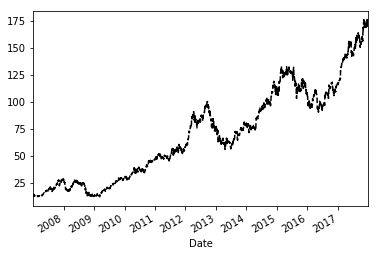

In [18]:
StockData['AAPL'].loc['2007-01-01':'2017-12-31'].plot(style='k--')

Normal plotting can be misleading for stocks - the last year of the data in the plot above appears to be a much more significant change than during the first two years, but on a percentage basis this is not the case.

A plot with a logarithmic Y scale will be more accurate.

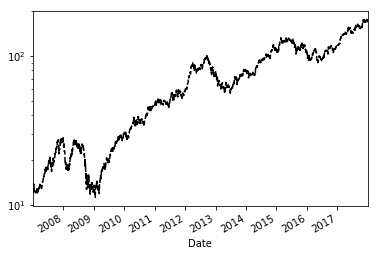

In [19]:
StockData['AAPL'].loc['2007-01-01':'2017-12-31'].plot(style='k--').set_yscale('log')

# Generate a moving average for one stock

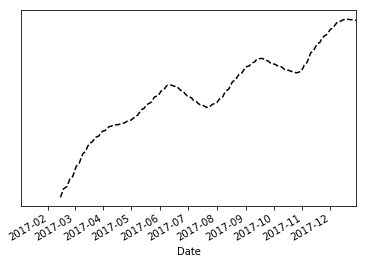

In [20]:
StockData['AAPL'].loc['2017-1-1':'2017-12-31'].rolling(window=30).mean().plot(style='k--').set_yscale('log')

# Breaking this command down...
#
# StockData['Apple']                   => Grab only the column named 'Apple' from the DataFrame
#     .loc['2017-1-1':'2017-12-31']    => Narrow that data down to just this date range
#     .rolling(window=30)              => Present rolling groups of 30 values
#     .mean()                          => Calculate the average of each group of 30
#     .plot(style='k--')               => Plot that average
#
# We never assigned this data to anything, so we just generated the data, plotted
# it, and then threw it away.

# Generate several moving averages for each stock

In [21]:
for Stock in Stocks:
    (Ticker, Name) = Stock

    StockData[Ticker + '-ma30'] = StockData[Ticker].rolling(window=30).mean()
    StockData[Ticker + '-ma60'] = StockData[Ticker].rolling(window=60).mean()
    StockData[Ticker + '-ma90'] = StockData[Ticker].rolling(window=90).mean()

# Generating new colums in a pandas.DataFrame is easy, just assign to a new column name.
# If the column already exists it is overwritten, if it doesn't already exist it is created.
# Pandas automatically keeps track of the indices for us.

In [22]:
sorted(StockData.columns)  # Show all the colums in the pandas.DataFrame

['AAPL',
 'AAPL-ma30',
 'AAPL-ma60',
 'AAPL-ma90',
 'AMZN',
 'AMZN-ma30',
 'AMZN-ma60',
 'AMZN-ma90',
 'DELL',
 'DELL-ma30',
 'DELL-ma60',
 'DELL-ma90',
 'FB',
 'FB-ma30',
 'FB-ma60',
 'FB-ma90',
 'GOOG',
 'GOOG-ma30',
 'GOOG-ma60',
 'GOOG-ma90',
 'LNKD',
 'LNKD-ma30',
 'LNKD-ma60',
 'LNKD-ma90',
 'MSFT',
 'MSFT-ma30',
 'MSFT-ma60',
 'MSFT-ma90',
 'NFLX',
 'NFLX-ma30',
 'NFLX-ma60',
 'NFLX-ma90',
 'TWTR',
 'TWTR-ma30',
 'TWTR-ma60',
 'TWTR-ma90',
 'VMW',
 'VMW-ma30',
 'VMW-ma60',
 'VMW-ma90']

# Plot each stock for the past year with its moving average

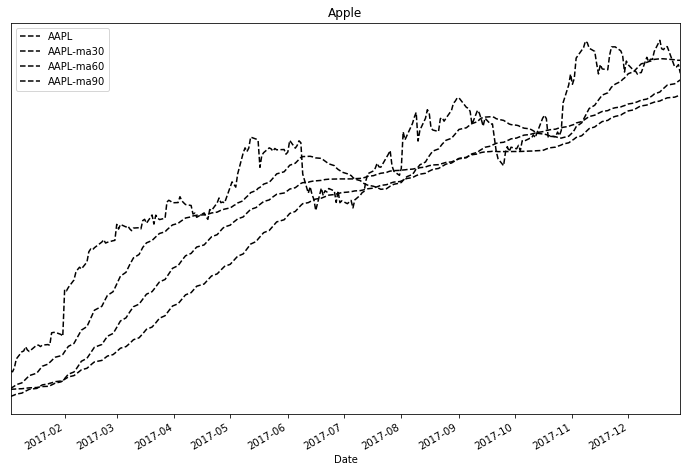

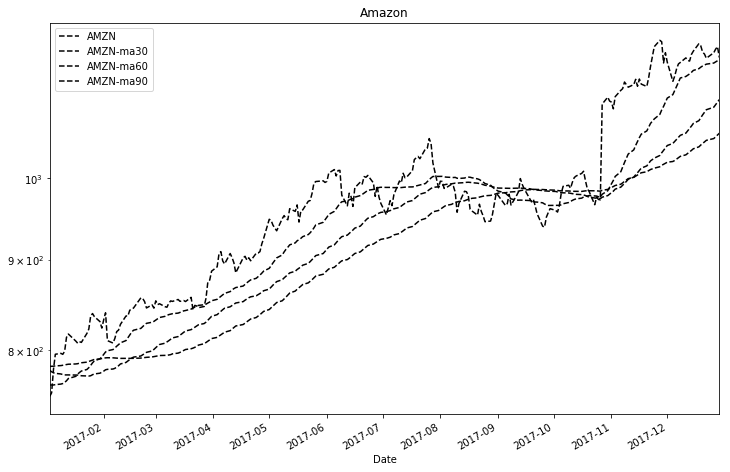

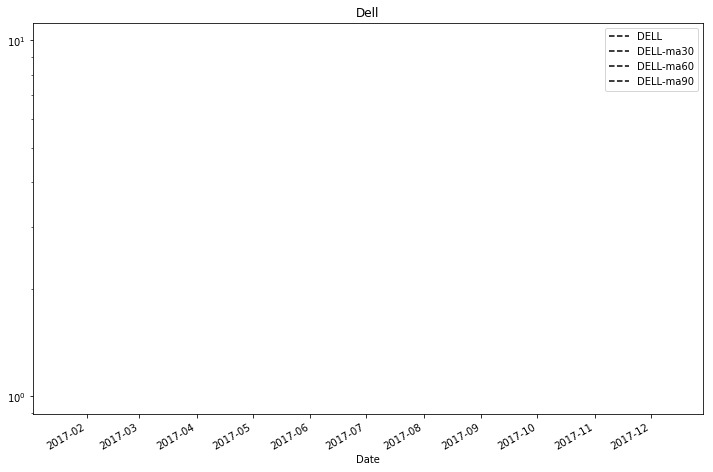

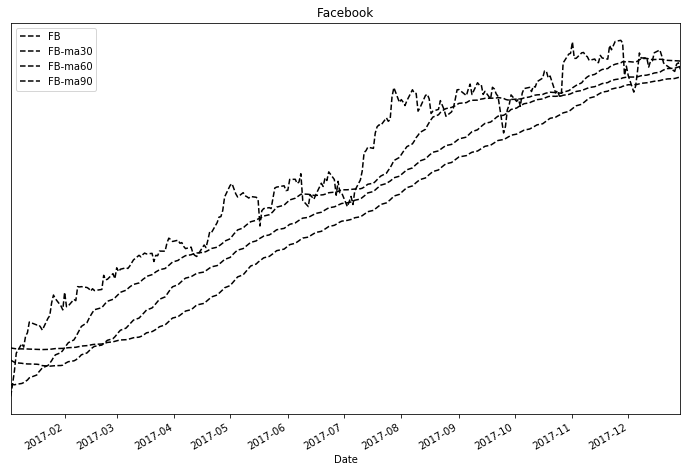

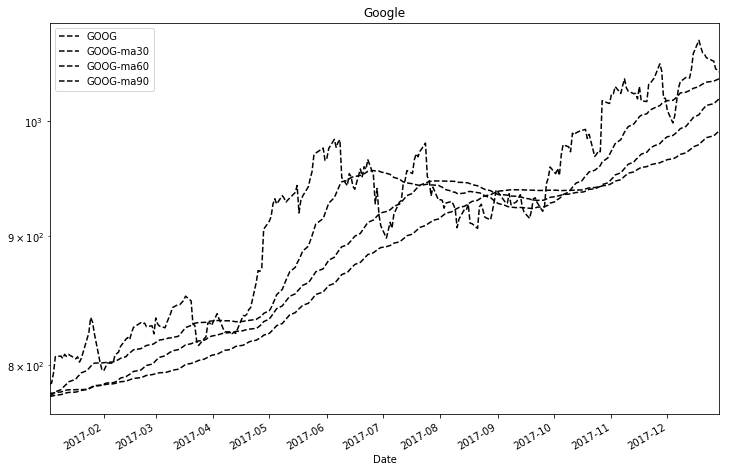

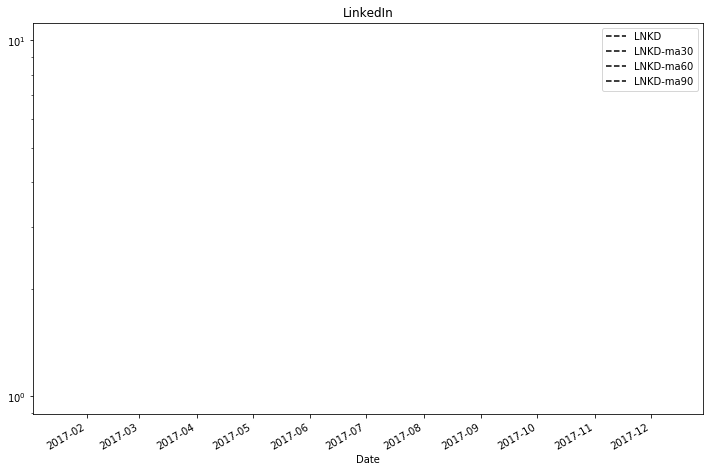

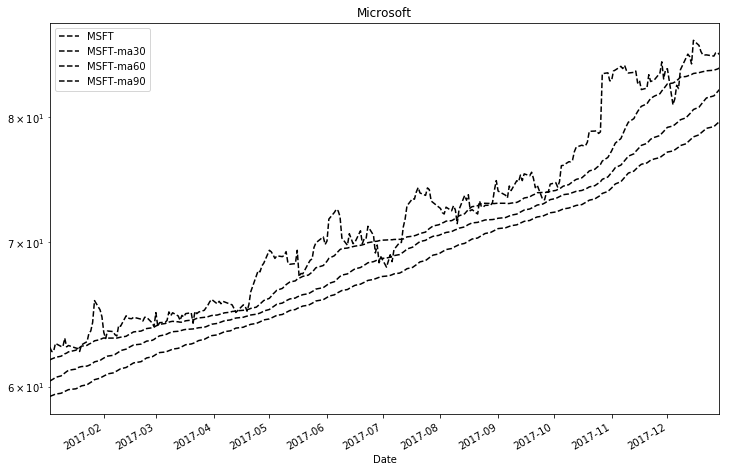

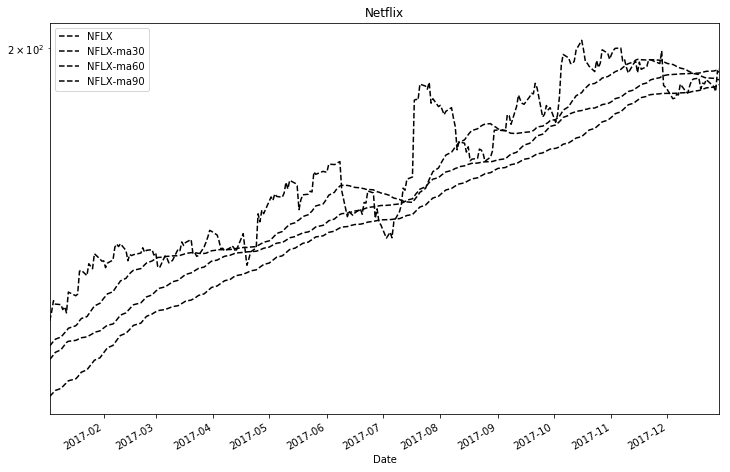

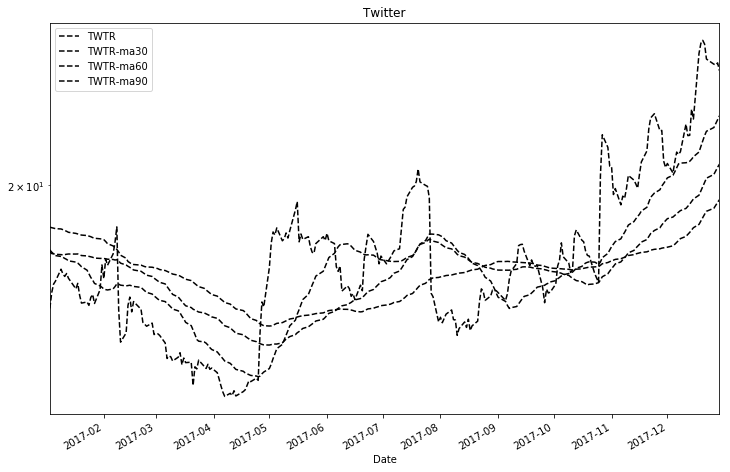

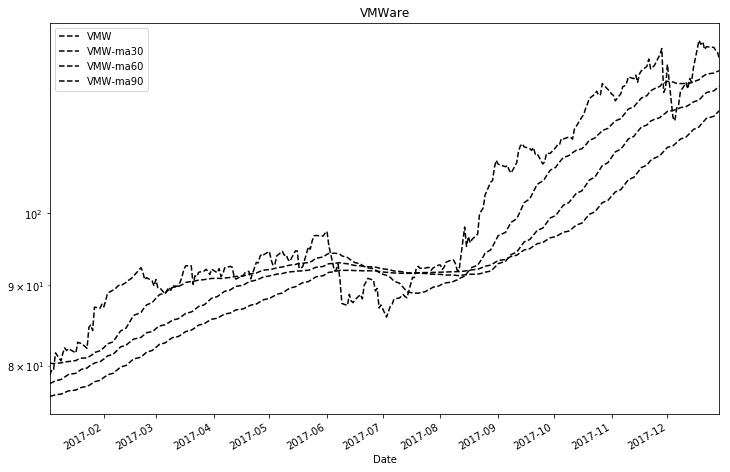

In [23]:
for Stock in Stocks:
    (Ticker, Name) = Stock
    PlotItems = [Ticker, Ticker + '-ma30', Ticker + '-ma60', Ticker + '-ma90']
    StockData[PlotItems].loc['2017-1-1':].plot(title=Name, style='k--', figsize=(12,8)).set_yscale('log')

## Other things we might like to do...
- Some charts have no data in the date range requested.  Suppress the plotting of charts with no data.
- It's hard to tell which line is which in the charts.  Fix this by making each line a different color in the charts.
- The vertical scale on each chart is automatically generated, which makes a stock that has changed 1% look just as volatile as one that has changed 100%.  Make the vertical scale the same for all charts to allow better comparisons between stocks.
- Add a percent scale to the right side of the graphs.

# Save our data in a CSV file

In [24]:
StockDataFilename = 'StockData.csv'  # We could embed the date or other identifying information into the file name

StockData.to_csv(StockDataFilename, index=False)

In [25]:
# A CSV file can be easily read into another program, or into Excel
!ls -l

total 4504
-rw-r--r--  1 dannymulligan  staff   172879 Jan 30 13:20 Backup_in_case_I_dont_have_Internet.csv
-rw-r--r--  1 dannymulligan  staff  1329237 Jan 30 13:20 StockData.csv
-rw-r--r--  1 dannymulligan  staff   795410 Jan 30 13:18 Using_Python_instead_of_Excel.ipynb


,AAPL,AMZN,DELL,FB,GOOG,LNKD,MSFT,NFLX,TWTR,VMW,...,NFLX-ma30,NFLX-ma60,NFLX-ma90,TWTR-ma30,TWTR-ma60,TWTR-ma90,VMW-ma30,VMW-ma60,VMW-ma90,nAAPL
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,11.97,38.70,25.49,NaN,233.56,NaN,29.86,3.80,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2007-01-04,12.24,38.90,26.24,NaN,241.39,NaN,29.81,3.62,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2007-01-05,12.15,38.37,26.16,NaN,243.35,NaN,29.64,3.54,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2007-01-08,12.21,37.50,26.17,NaN,241.55,NaN,29.93,3.40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2007-01-09,13.22,37.78,26.84,NaN,242.51,NaN,29.96,3.43,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2007-01-10,13.86,37.15,27.26,NaN,244.49,NaN,29.66,3.44,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2007-01-11,13.69,37.40,26.93,NaN,249.61,NaN,30.70,3.46,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2007-01-12,13.52,38.20,26.62,NaN,252.25,NaN,31.21,3.24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2007-01-16,13.87,38.66,26.51,NaN,251.89,NaN,31.16,3.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
